## Backtesting a Swing Trading Strategy using WMA, VI, CMF, CHOP and SuperTrend Indicators

This is an example of how a simple algorithmic trading strategy based on WMA (Weighted Moving Average), VI (Vortex Indicator), CMF (Chaikin Money Flow), CHOP (Choppiness Index), and the SuperTrend indicator can be implemented for backtesting and to calculate the expected P & L. In addition, the ATR (Average True Range)-based SuperTrend indicator also serves as a trailing Stop Losses (SL) to define our exits.

The strategy is as follows:
- Entry Signal: Close Price > WMA200, +VI > 1, CMF > 0, CHOP < 50, Close Price > SuperTrend
- Exit Signal: Close Price < SuperTrend

As an example, the strategy will be applied on the daily price data from 2018 - 2023 scraped from Yahoo Finance for a Silver ETF (iShares Silver Trust) ([SLV](https://uk.finance.yahoo.com/quote/SLV)). In this simple strategy, we are only going to go long when a signal arises & sell when our SL is hit (no short trades). Fees, spread and slippage have not been accounted for.

**Disclaimer:**
- This code is presented for *educational purposes only*. Do your own due diligence & trade at your own discretion. The code can be used a starting point to develop more advanced strategies, but please don't use it in its current form to execute real trades in the financial markets using your own hard-earned cash (or, worse, someone else's cash).

### Section 1 - Data Loading

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yfin
import datetime as dt
plt.style.use('bmh')
%matplotlib inline

In [2]:
# get the close prices for the stock
start_date = dt.datetime(2018,5,10)
end_date = dt.datetime(2023,5,10)

df = yfin.download('SLV', start=start_date, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-05-10,15.73,15.78,15.68,15.74,15.74,8470600
2018-05-11,15.83,15.85,15.68,15.70,15.70,6681200
2018-05-14,15.68,15.71,15.54,15.56,15.56,7360100
2018-05-15,15.32,15.36,15.26,15.33,15.33,10317400
2018-05-16,15.35,15.47,15.32,15.41,15.41,7638200


### Section 2 - Buy & Sell Signals

Buy when:
- Close Price > WMA200
- +VI > 1
- CMF > 0
- CHOP < 50
- Close Price > SuperTrend

Sell when:
- Close Price < SuperTrend

The functions for the various indicators can be found in a file named ['TA_indicators_v1.py'](https://github.com/R-Budhidarmo/Algorithmic-Trading-Backtest/blob/main/TA_indicators_v1.py) in this repo.

In [3]:
# call the functions for the indicators
from TA_indicators_v1 import *

df = ATR(df,14)
df = CHOP(df,14)
df = CMF(df,12)
df = VI(df,12)
df = WMA(df,200)
df = super_trend(df,3,10)

/var/folders/7l/b7q7m6_92vd8wdnm3n_8cn800000gn/T/ipykernel_14686/3061817796.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)


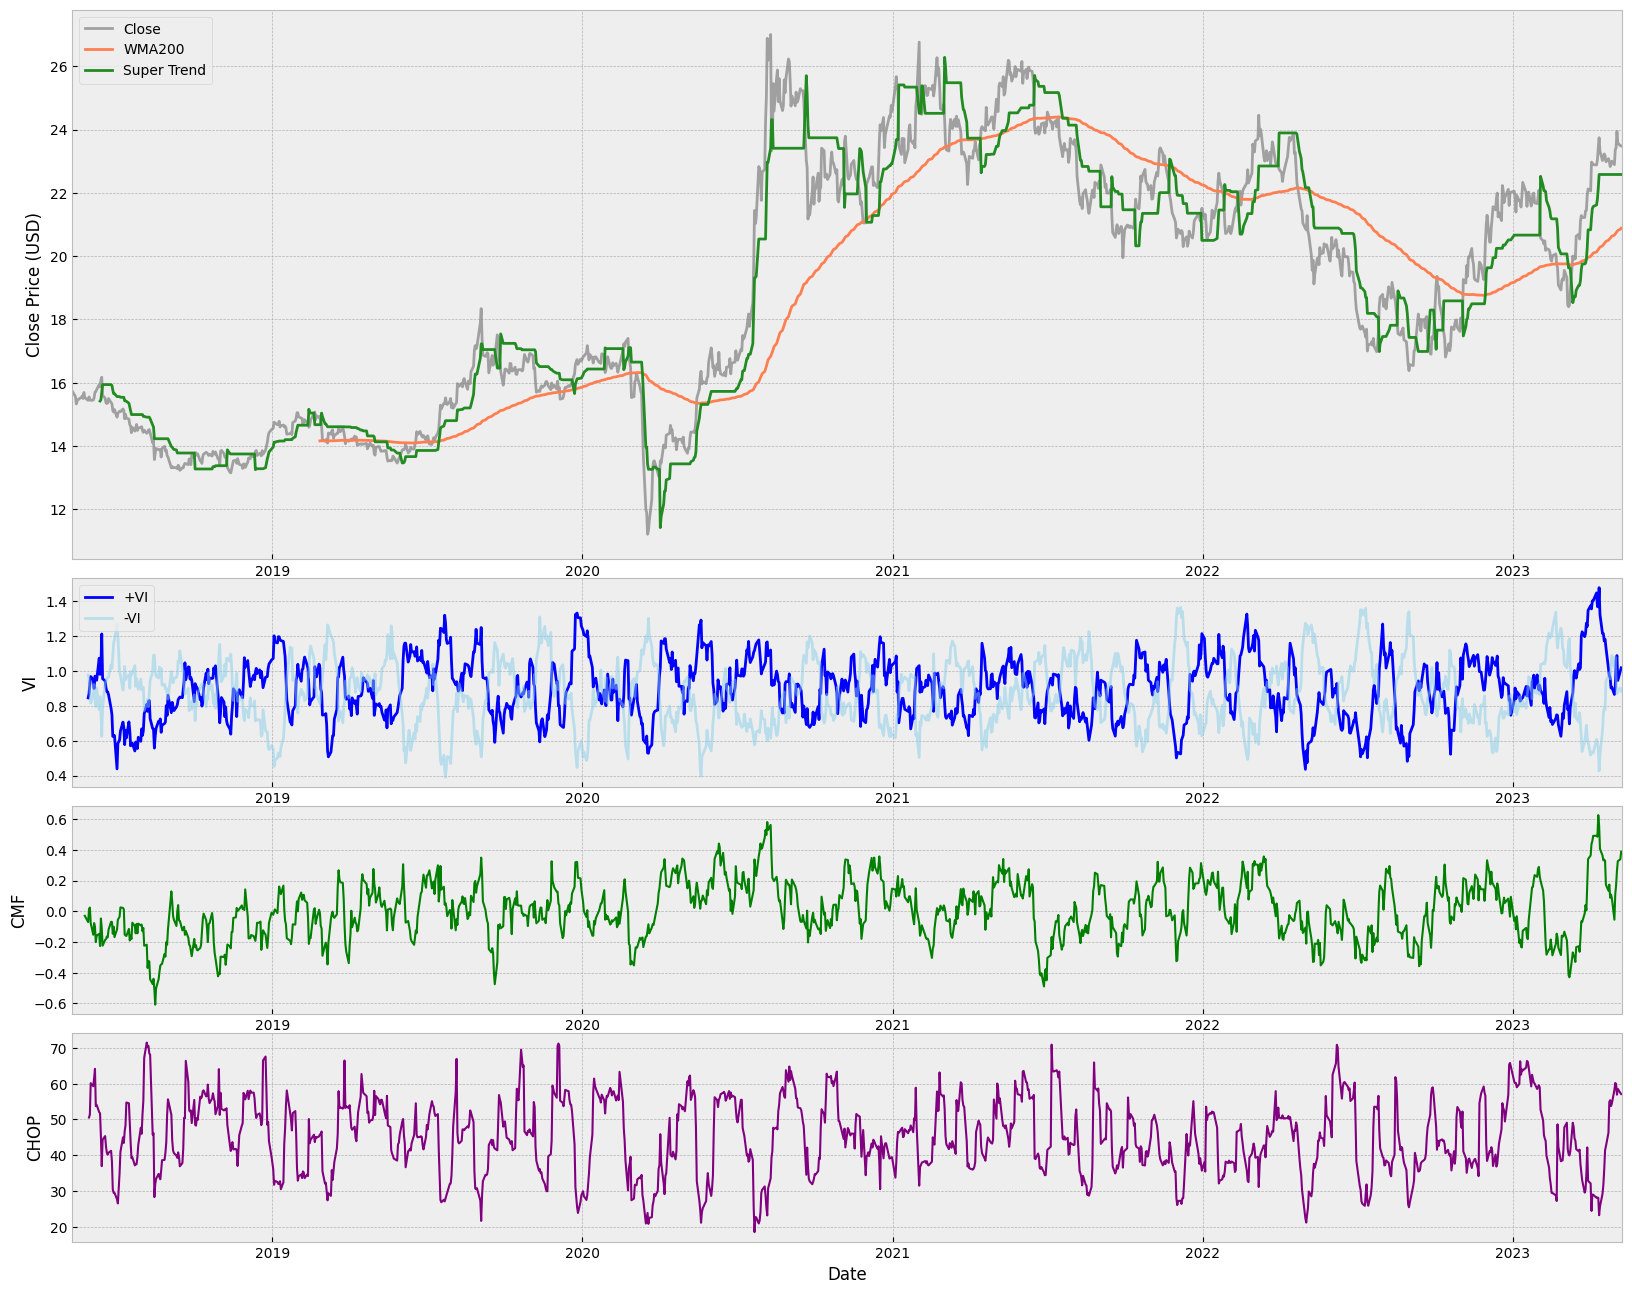

In [4]:
# create a visualisation for the price and the indicators
fig = plt.subplots(figsize=(20,16))
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (5,0), rowspan = 2, colspan = 1)
ax3 = plt.subplot2grid((11,1), (7,0), rowspan = 2, colspan = 1)
ax4 = plt.subplot2grid((11,1), (9,0), rowspan = 2, colspan = 1)

ax1.plot(df['Close'], label='Close', c='grey', alpha=0.7)
ax1.plot(df['WMA200'], label='WMA200', c='coral')
ax1.plot(df['SuperTrend'], label='Super Trend', c='forestgreen')
ax1.set_ylabel('Close Price (USD)')
ax1.set_xbound(lower = start_date, upper = end_date)
ax1.legend(loc='upper left')

ax2.plot(df['VI+'], color='blue', label='+VI')
ax2.plot(df['VI-'], color='skyblue', alpha=0.5, label='-VI')
ax2.set_ylabel('VI')
ax2.set_xbound(lower = start_date, upper = end_date)
ax2.legend(loc='upper left')

ax3.plot(df['CMF'], color = 'green', linewidth = 1.5, label = 'CMF')
ax3.set_xbound(lower = start_date, upper = end_date)
ax3.set_ylabel('CMF')

ax4.plot(df['CHOP'], color = 'purple', linewidth = 1.5, label = 'CHOP')
ax4.set_xbound(lower = start_date, upper = end_date)
ax4.set_ylabel('CHOP')
ax4.set_xlabel('Date')

plt.show()

In [5]:
# define a function for the trading strategy
def strategy(data):

    position = 0
    buy_price = []
    sell_price = []

    for i in range(len(data)):
        if (data['Close'][i] > data['WMA200'][i]) and (data['VI+'][i] > 1) and (data['CMF'][i] > 0) and (data['CHOP'][i] < 50) and (data['Close'][i] > data['SuperTrend'][i]) and (position == 0):
            position = 1
            buy_price.append(data['Close'][i])
            sell_price.append(np.nan)

        elif (position == 1) and ((data['Close'][i] < data['SuperTrend'][i])):
            position = 0
            sell_price.append(data['Close'][i])
            buy_price.append(np.nan)

        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)

    return(buy_price, sell_price)

In [6]:
buy_price, sell_price = strategy(df)
df['Entry'] = buy_price
df['Exit'] = sell_price

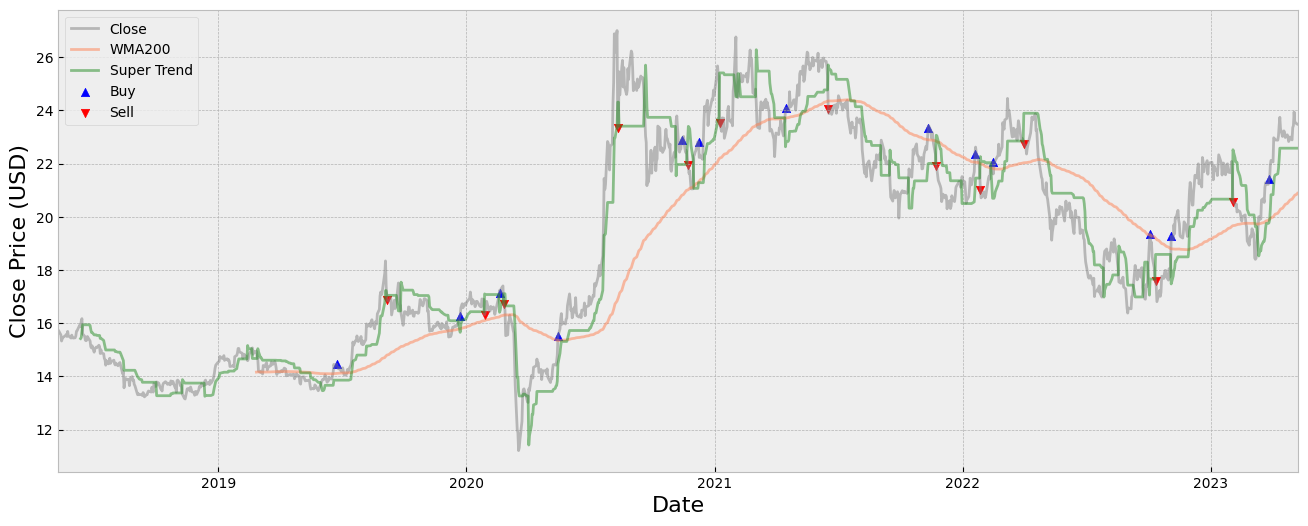

In [7]:
# visualise the buy & sell signals on the price chart
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df['Close'], label='Close', c='grey', alpha=0.5)
ax.plot(df['WMA200'], label='WMA200',  c='coral', alpha=0.5)
ax.plot(df['SuperTrend'], label='Super Trend', c='forestgreen', alpha=0.5)
ax.scatter(df.index, df['Entry'], label = 'Buy', alpha = 1, marker = '^', color = 'blue')
ax.scatter(df.index, df['Exit'], label = 'Sell', alpha = 1, marker = 'v', color = 'red')
plt.xlim(left=start_date, right=end_date)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price (USD)', fontsize=16)
plt.legend(loc='upper left')
plt.show()

### Section 3 - P & L Calculations

In this section, we'll calculate the overall profit / loss generated using the strategy. The assumptions are as follows:
- our starting capital is GBP 100,000 
- our position size per trade is GBP 2000 (i.e. 2% of starting capital)
- we use 50 x leverage per trade
- Fees, spreads & slippage have not been taken into account

The function to calculate the P & L, generate a summary table & chart can be in a file named ['PnL_calculations_v1.py'](https://github.com/R-Budhidarmo/Algorithmic-Trading-Backtest/blob/main/PnL_calculations_v1.py) in this repo.

In [8]:
# define the position size per trade & leverage
initial_investment = 100000
size_per_trade = 2000
leverage = 50

SUMMARY STATISTICS
---------------------------------------------------------------------------------
Total number of trades: 	 	 	 13
Average holding period (days): 	 	 	 39.46
Average win size: 	 	 	 	 12836.01
Average loss size: 	 	 	 	 -4702.04
Win rate of the strategy: 	 	 	 53.85 %
Reward-to-Risk ratio: 	 	 	 	 2.73
Expectancy of the strategy: 	 	 	 9081.87
The strategy has a POSITIVE expectancy
---------------------------------------------------------------------------------
Maximum drawdown (without using leverage): 	 	 	 288.07
Maximum drawdown (with 50 x leverage): 	 	 	 	 14403.61
---------------------------------------------------------------------------------
Percent gain or loss by the end of period (without leverage): 	 1.23 %
Percent gain or loss by the end of period (with 50 x leverage):	 61.64 %
Percent gain or loss by the end of period (buy-and-hold): 	 49.17 %
---------------------------------------------------------------------------------
Capital value by the end o

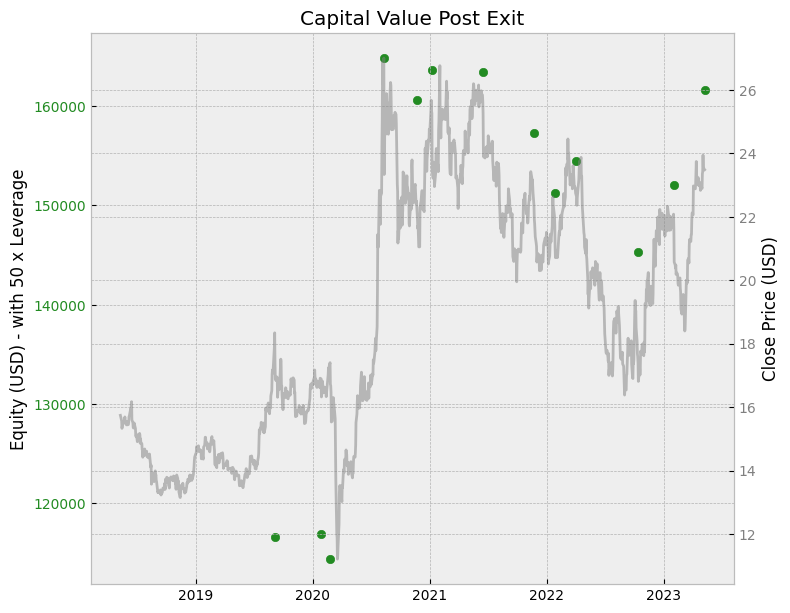

In [9]:
from PnL_calculations_v1 import *
df = PnL_long(df, buy_price, sell_price, initial_investment, size_per_trade, leverage)

**Conclusions:**
- Using this strategy, the maximum drawdown was around USD 14,400 (14.4% of the initial invested) when we use 50 x leverage.
- In total, within the 5-year period we bought and sold 13 times, with an average holding period of around 40 days per trade.
- The win rate is just under 54%, the reward-to-risk ratio is over 2.5, and the strategy has a positive expectancy overall.
- At the end of the period, the value of our investment had gone up by 61%. If we simply buy and hold, we would've gained just under 50% by the end of the period.
- Overall, altough more indicators were used in this strategy compared to a similar [EMA_MACD_SuperTrend strategy](https://github.com/R-Budhidarmo/Algorithmic-Trading-Backtest/blob/main/EMA_MACD_SuperTrend_strategy.ipynb), the overall summary statistics are quite similar. Perhaps, because the decisions to buy and sell were all based on indicators that are essentially trend-following, the end results turned our to be not too far apart.